<img src="https://i.imgur.com/X0sSnwp.png">

<p align="center">
<b>Cycles</b>
<img src="https://i.imgur.com/CC3TkAf.png">
</p>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "/content/drive/MyDrive/Time Series Datasets/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


<Figure size 720x720 with 0 Axes>

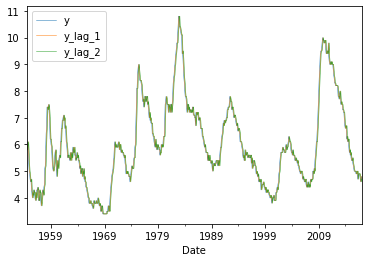

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
df.plot(linewidth=0.5)

In [10]:
from statsmodels.tsa.stattools import adfuller
# ADF Test
result = adfuller(df.y, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

if result[1]<0.05:
  print("Data is Stationary")
else:
  print("Data is non-stationary")

ADF Statistic: -3.4411959538596193
n_lags: 16
p-value: 0.00963215088021802
Critial Values:
   1%, -3.4392782790913206
Critial Values:
   5%, -2.865480319267325
Critial Values:
   10%, -2.568868260909806
Data is Stationary


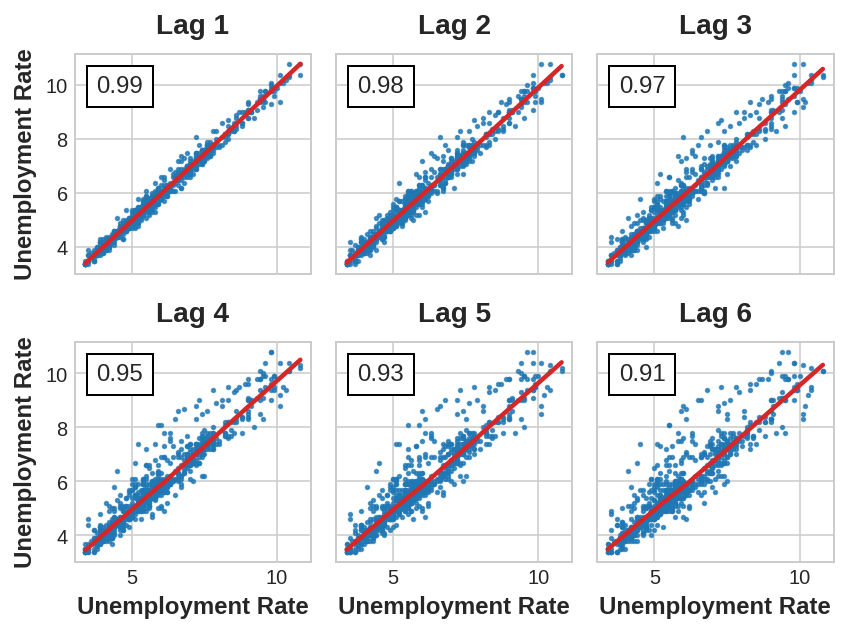

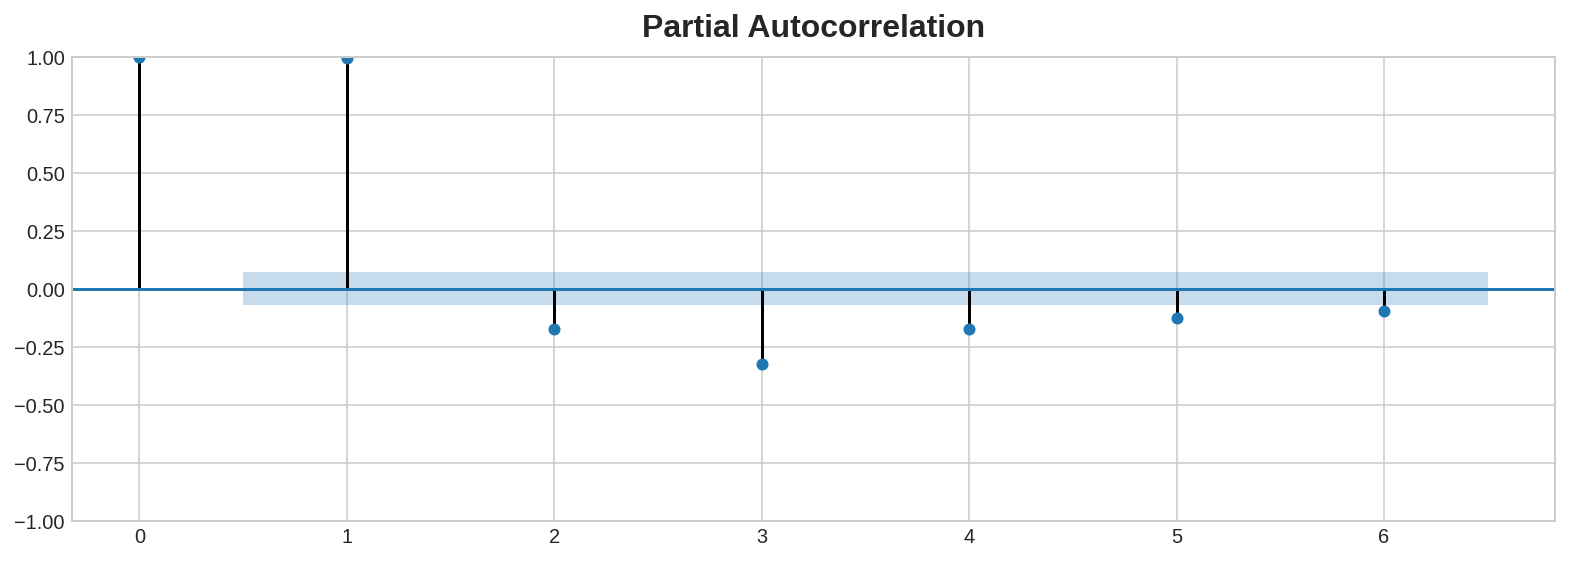

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

_ = plot_lags(y, lags=6, nrows=2)
_ = plot_pacf(y, lags=6)

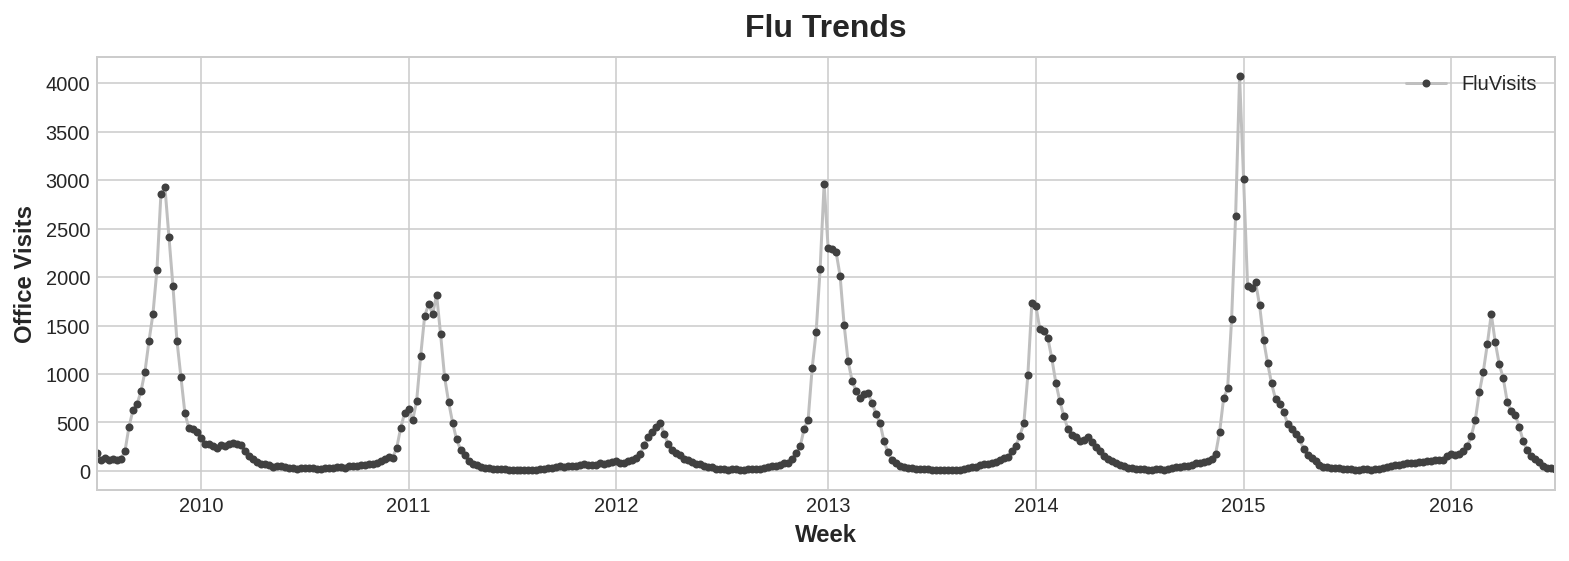

In [40]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("/content/drive/MyDrive/Time Series Datasets")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
) # Change column Week as period index 
flu_trends.drop("Week", axis=1, inplace=True) # Drop the Week column because we have set it as index already so we don't need it.

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")
ax.legend()

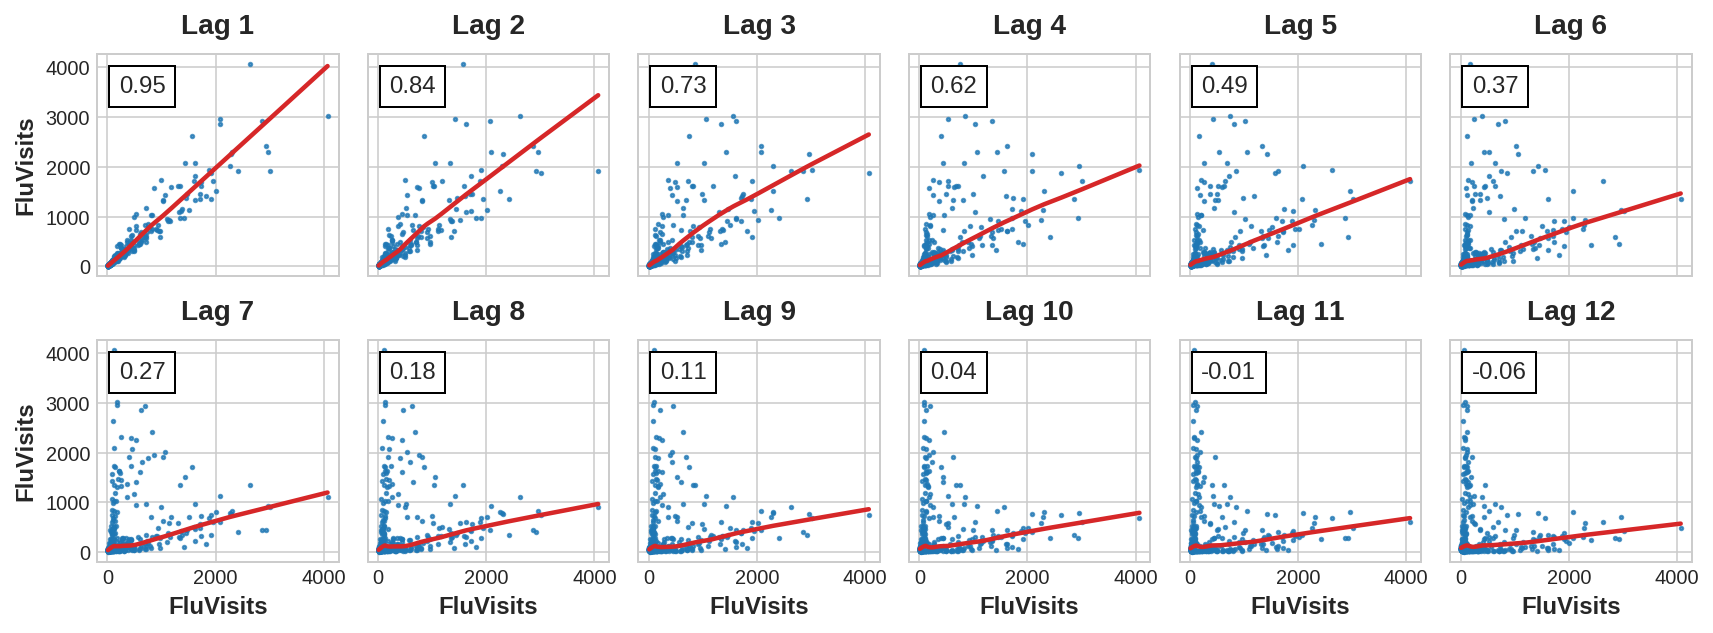

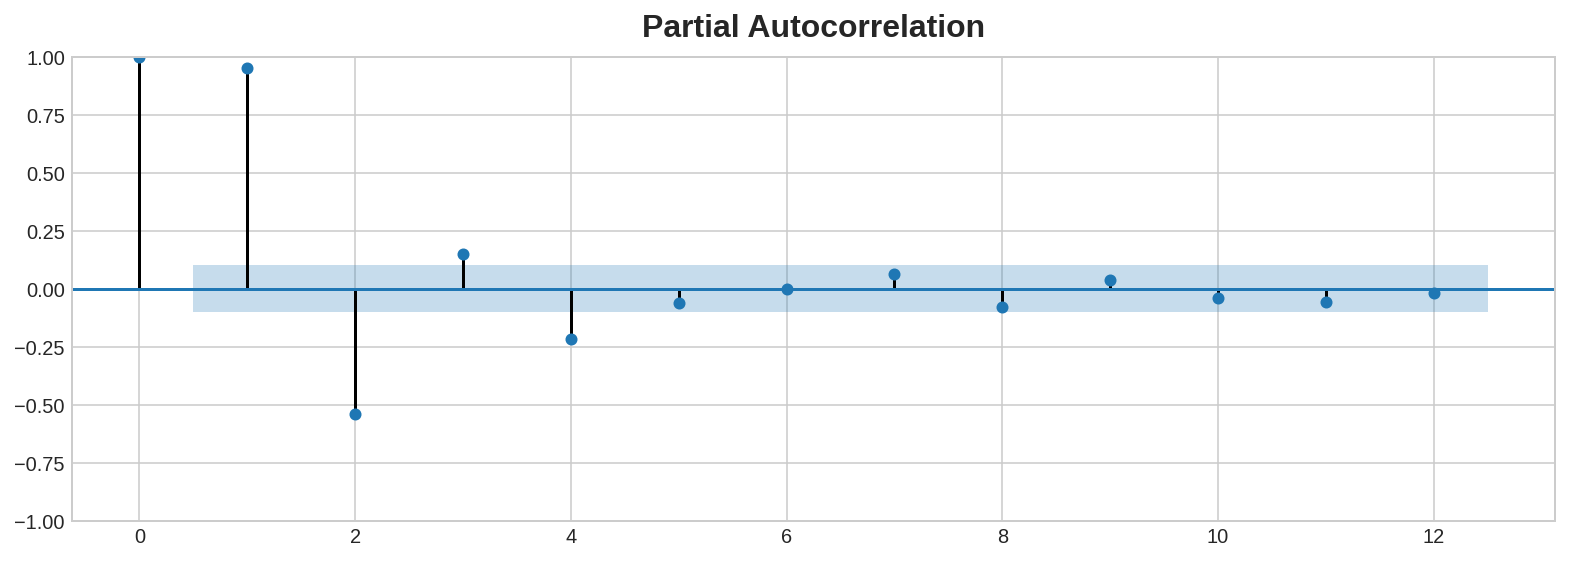

In [41]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

# **Adfuller test (ADF)**
To check stationarity in the data we use adfuller test.
If the p-value is more than 0.05 than the data is non-stationary. This is also called the null hypothesis testing.

$H_0=\text{The data is non-stationary if $p>0.05$}$

$H_1 =\text{The data is stationary if $p<0.05$}$

In [16]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(flu_trends.FluVisits.dropna(),autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
print(f'observations: {result[3]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1]<0.05:
  print("Data is Stationary")
else:
  print("Data is non-stationary")

ADF Statistic: -5.607721010879484
n_lags: 4
p-value: 1.2233598391927046e-06
observations: 361
Critial Values:
   1%, -3.4485948978753314
Critial Values:
   5%, -2.86957971128312
Critial Values:
   10%, -2.571053050314224
Data is Stationary


The lag plots indicate that the relationship of FluVisits to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. We can lag a time series in Pandas with the shift method. For this problem, we'll fill in the missing values the lagging creates with 0.0.

In [17]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def make_leads(ts, leads, name='y'):
      return pd.concat(
          {f'{name}_lead_{i}': ts.shift(-i)
          for i in reversed(range(leads))},
          axis=1)

X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [18]:
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [19]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

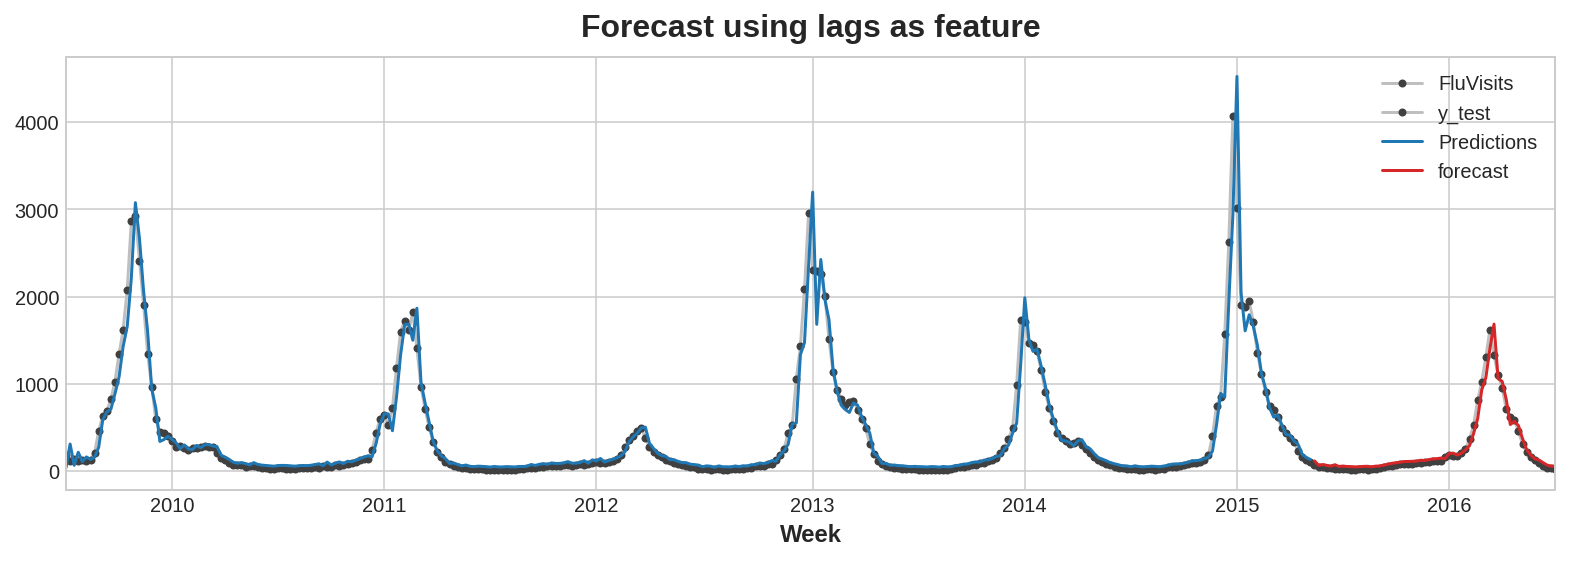

In [20]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params,label='y_test')
ax = y_pred.plot(ax=ax,label='Predictions')
_ = y_fore.plot(ax=ax, label='forecast',color='C3')
plt.title('Forecast using lags as feature')
ax.legend()

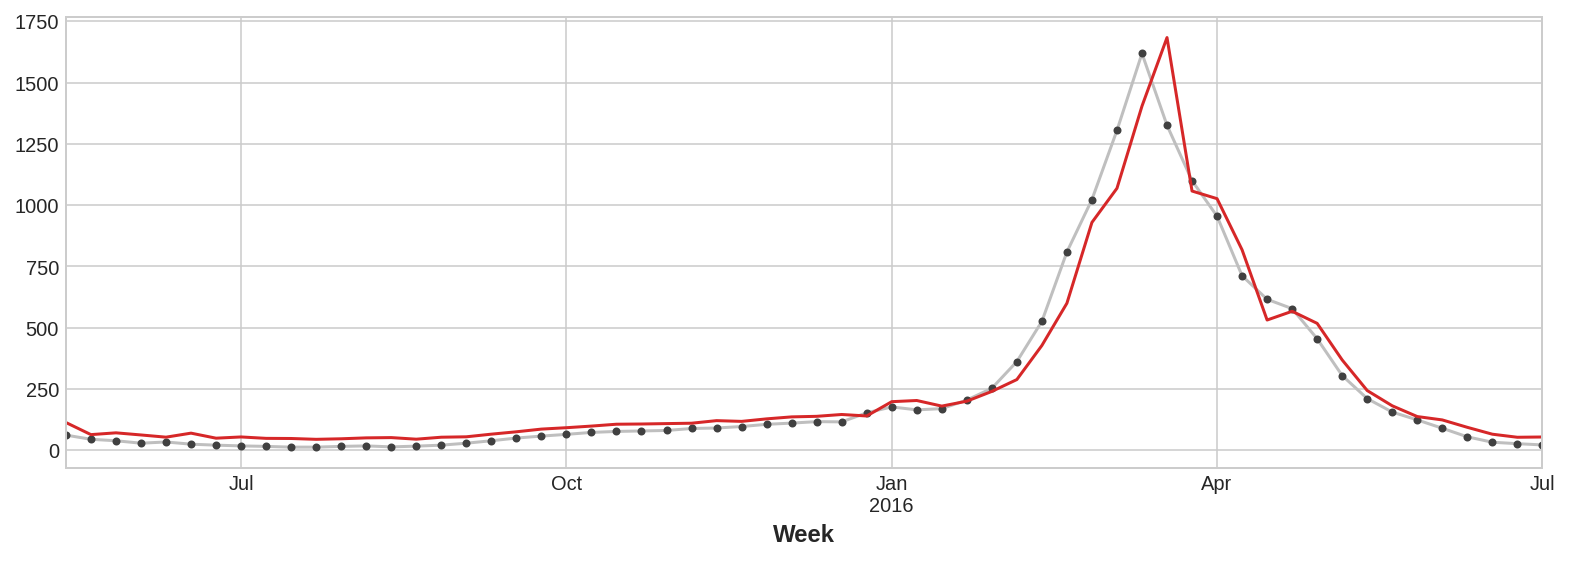

In [21]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

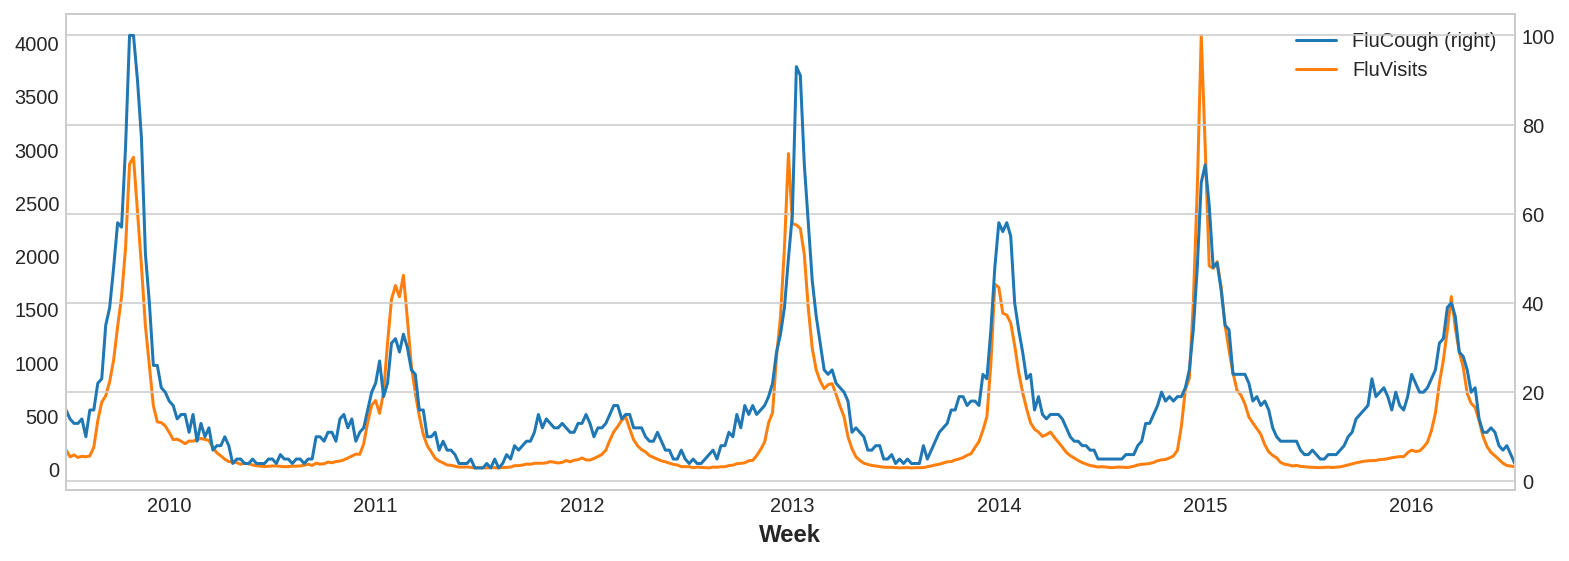

In [22]:
ax= flu_trends.plot(y=["FluCough", "FluVisits"],
    secondary_y="FluCough")

In [23]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

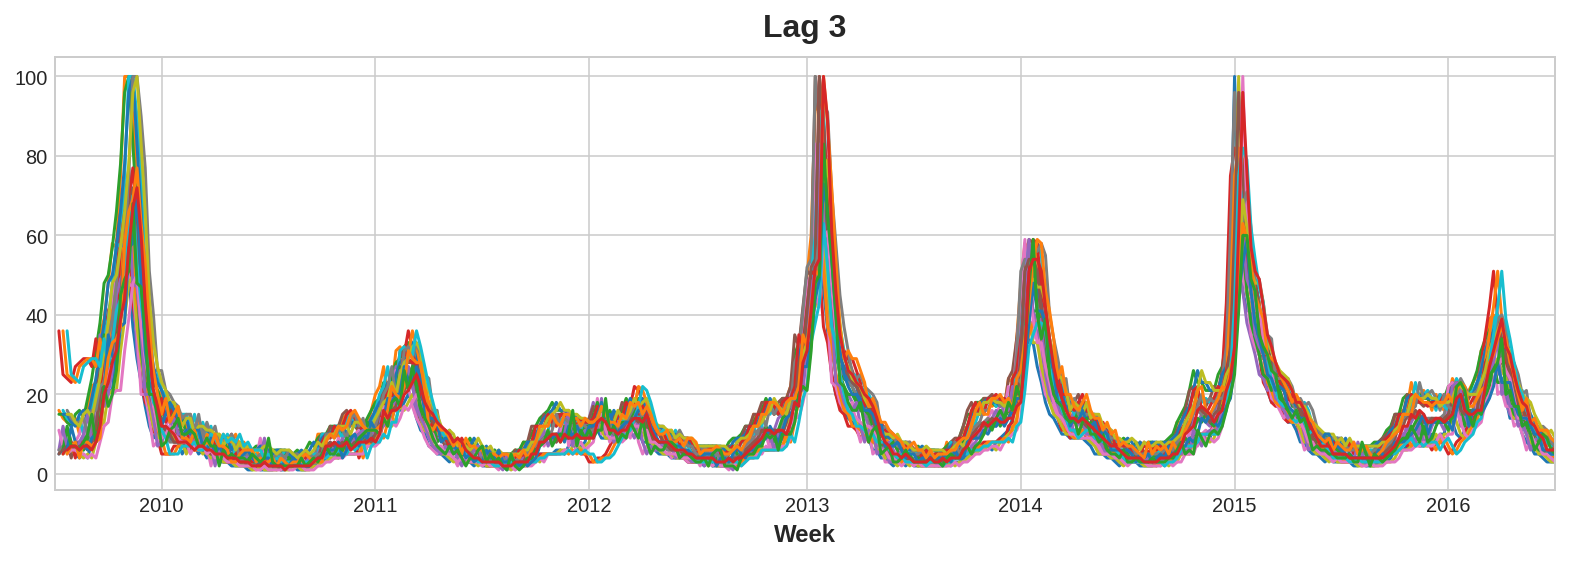

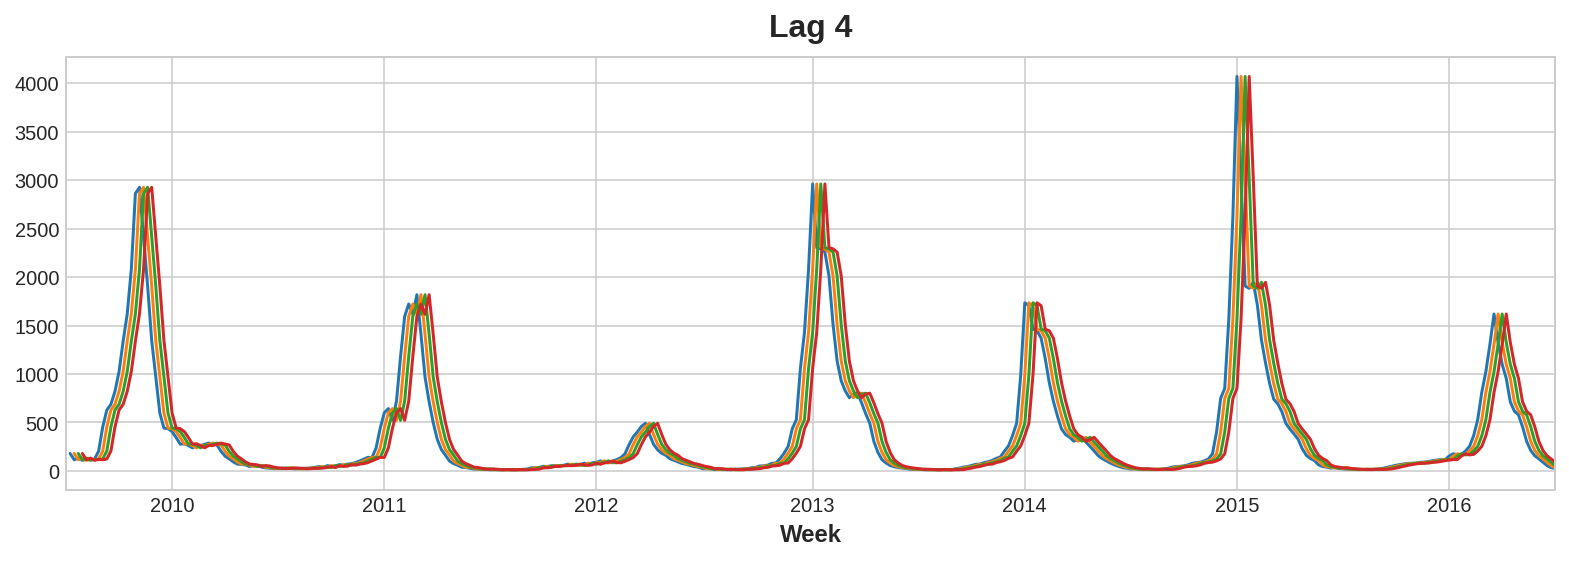

In [24]:
X0.plot(legend=False,title="Lag 3")
X1.plot(legend=False,title="Lag 4")

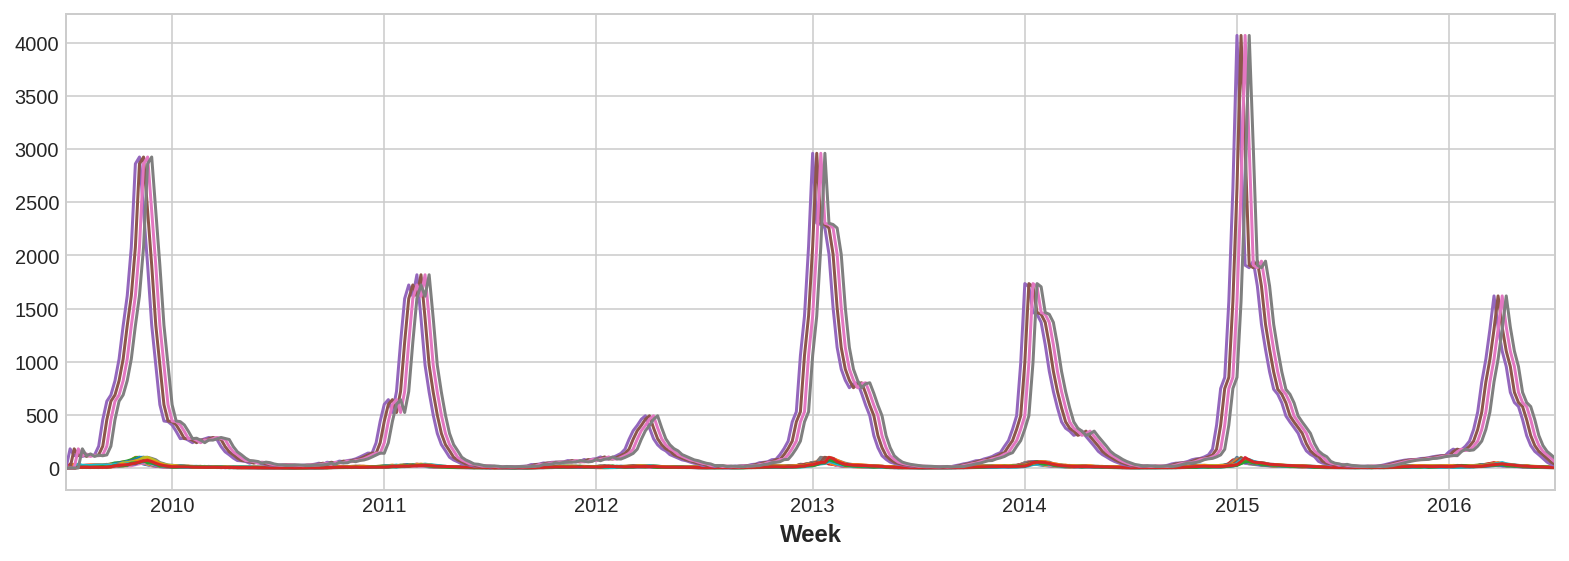

In [25]:
X.plot(legend=False)

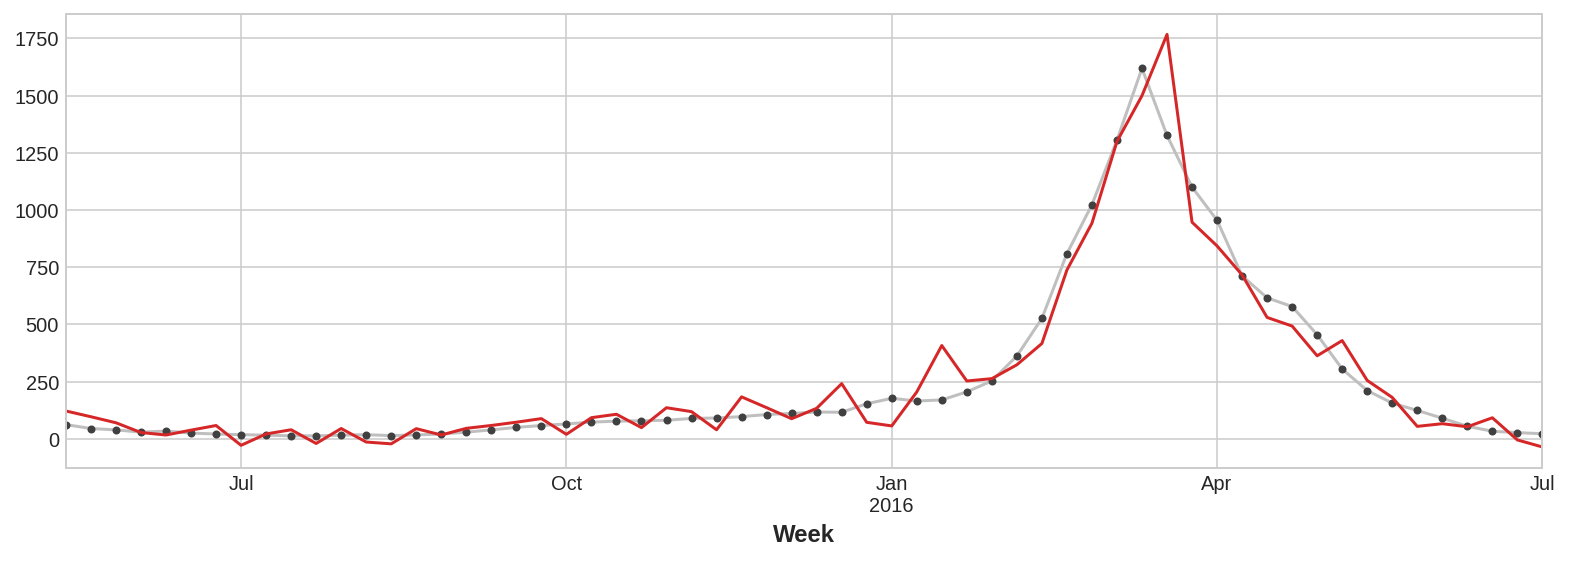

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

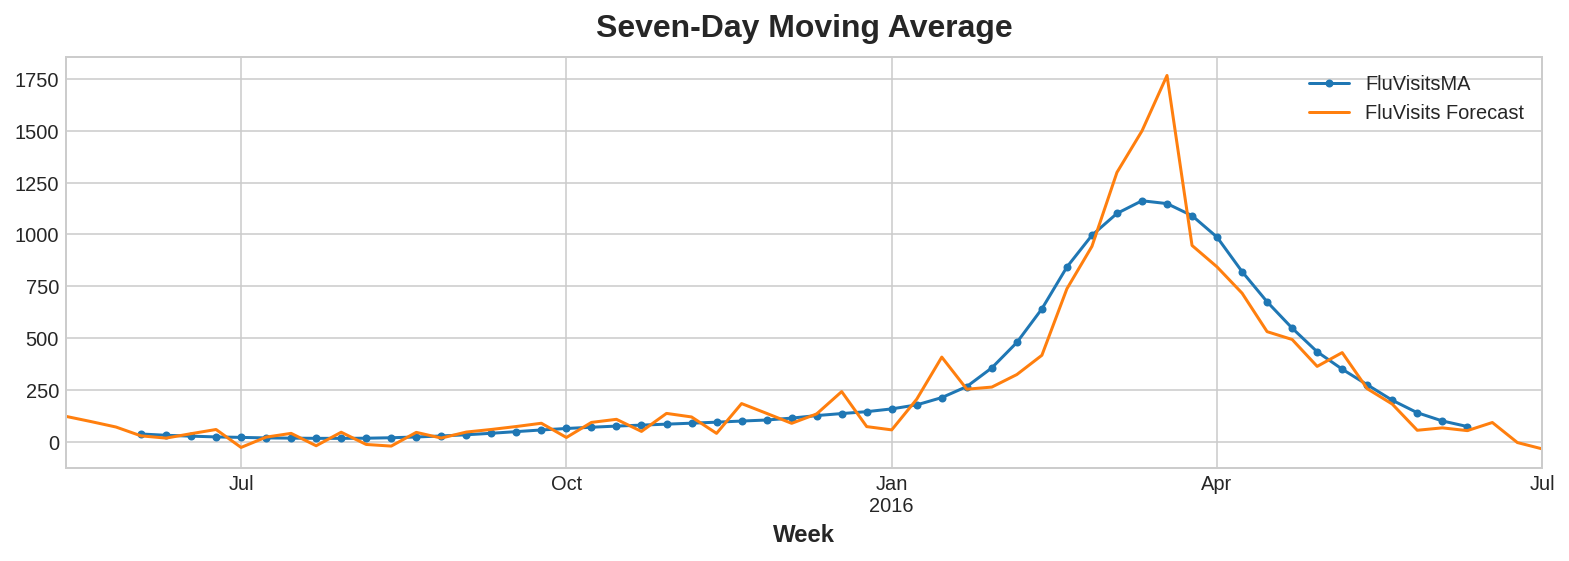

In [29]:
y_ma = y_test.rolling(
    window=7,    
    center=True
).mean()            


# Plot
ax = y_ma.plot(style='.-',label='FluVisitsMA')
ax = y_fore.plot(label='FluVisits Forecast')
ax.set_title("Seven-Day Moving Average");
ax.legend()

In [ ]:
!pip install --upgrade --no-deps statsmodels

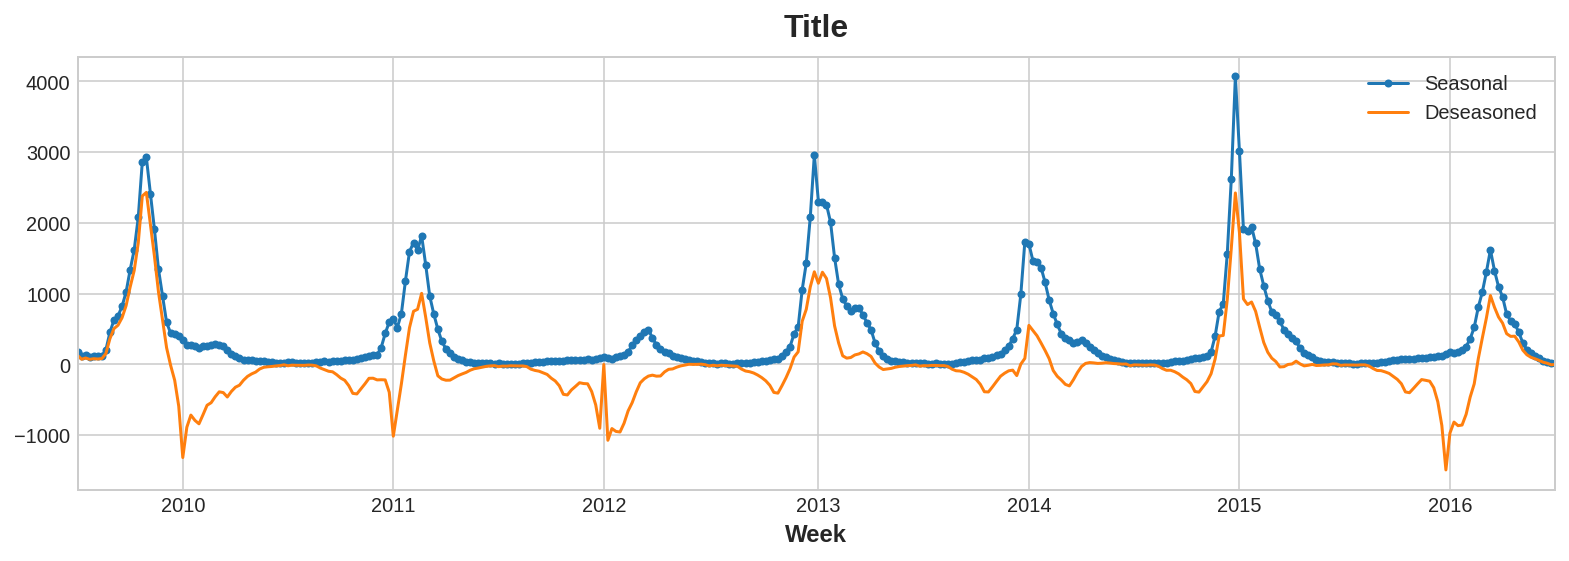

In [33]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='W', order=7)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'deseasoned'

ax = y.plot(style='.-')
ax = y_deseason.plot()
ax.set_title("Title")
ax.legend(['Seasonal','Deseasoned'])

In [53]:
def plot_lags2(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [ ]:
plot_lags2(x=y_train, y=y_deseason, lags=4, leads=4, nrows=1);

ValueError: ignored